# Data Exploration and Multivariable Analysis

This notebook will explore different exploration tools in order to determine that the data at hand is adequate for what we plan to use it -- in this case, a classification of the presence of organized crime in a given Mexican state from 2010 to 2016.

First, I'll read in the data we've been working with and impute with zero (which is the same as median imputation in our case), since it's what seemed to make the most sense from the previous notebook.

In [360]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import jellyfish
import importlib
importlib.reload(mdc)
importlib.reload(epc)

<module 'exploration_pca_ca' from '/Users/mariomoreno/Desktop/ML Projects/Mexico OC/exploration_pca_ca.py'>

In [336]:
# Reading in data
df = mdc.reading_in('data/Mexico_Final.xlsx')

In [337]:
mdc.impute_zero(df, {'costa_km':0}).head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios,pop
0,Aguascalientes,2010,40129,19250,20879,2727,144,2698,3239,325,...,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11,1195787
1,Baja California,2010,107624,53692,53932,6192,271,2342,9353,3241,...,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5,3224843
2,Baja California Sur,2010,23247,11780,11467,1588,76,1255,1660,296,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5,649616
3,Campeche,2010,28350,14349,14001,1975,106,3373,1179,144,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11,836747
4,Coahuila de Zaragoza,2010,82553,41397,41156,6219,330,23331,7867,545,...,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38,2782012


In [338]:
cols = mdc.find_missing_cols(df)

In [339]:
# loop to pull out the missing columns from the list above# 
cols_impute = []
for c in cols:
    cols_impute.append(c[0])

In [340]:
working_df = mdc.single_imputation(df, 'median', cols_impute)

### 1) Quick Data Exploration 

Part of the analysis is determining certain components of our data, which means doing a quick exploration of how different columns and states relate to each other. This will hopefully uncover outliers, highly correlated variables, and other worthwhile findings. Once this is done, we'll move on to the next step which is a quick standardization of the variables and then PCA and Cluster Analysis


Summary stats for entidad
count                           224
unique                           32
top       Tlaxcala                 
freq                              7
Name: entidad, dtype: object


Summary stats for year
count     224.000000
mean     2013.000000
std         2.004479
min      2010.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2016.000000
Name: year, dtype: float64


Summary stats for alumnos_inscritos_hs
count       224.000000
mean     139023.571429
std      116544.209387
min       23247.000000
25%       62133.250000
50%      108420.500000
75%      158046.250000
max      640965.000000
Name: alumnos_inscritos_hs, dtype: float64


Summary stats for hombres_inscritos_hs
count       224.000000
mean      69030.053571
std       57721.462175
min       11567.000000
25%       30118.750000
50%       54462.000000
75%       78666.500000
max      314509.000000
Name: hombres_inscritos_hs, dtype: float64


Summary stats for mujeres_inscritas_hs
cou

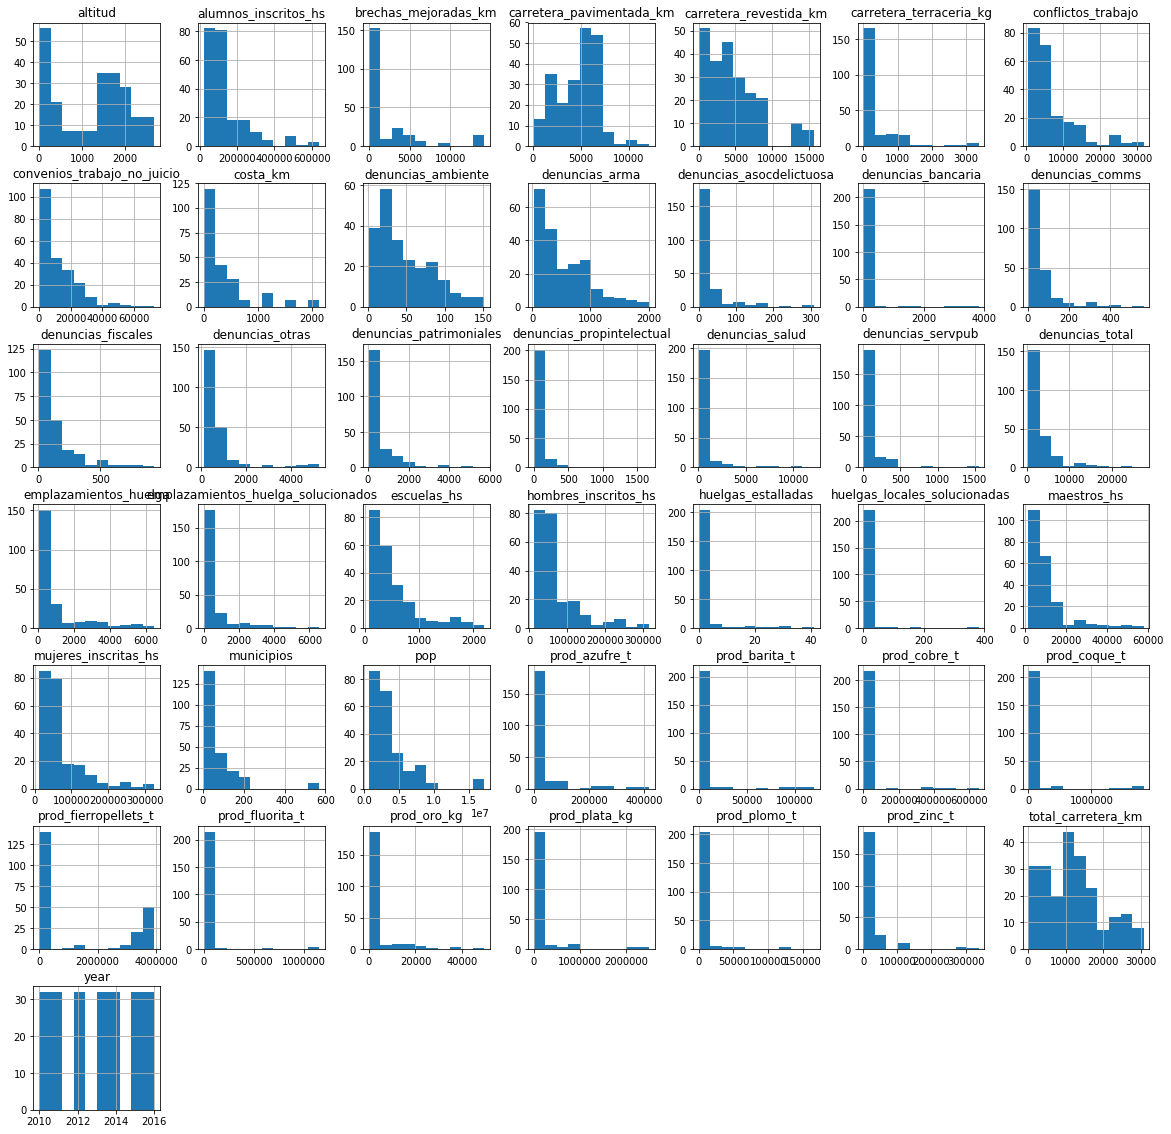

In [341]:
epc.explore_data(working_df)

Not that much to note from the histograms or descriptive statistics. I'll dive a little deeper in to outliers, as there are appears to be some...but that might be a function of the disparate populations within states and the large number of population dependent variables.

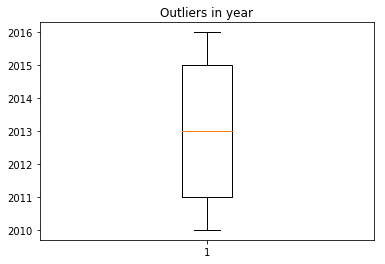

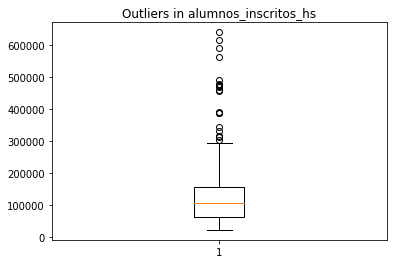

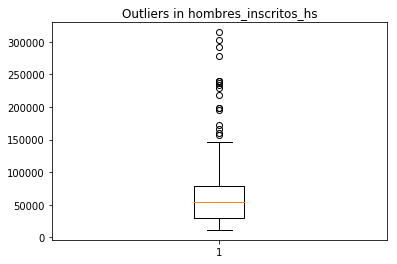

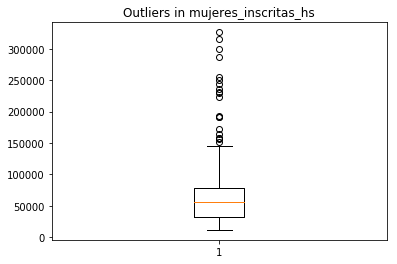

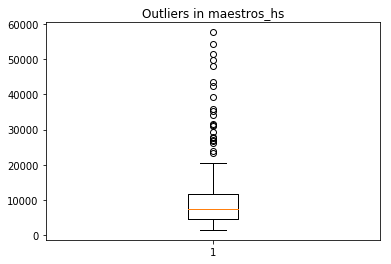

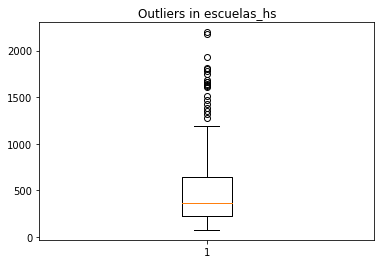

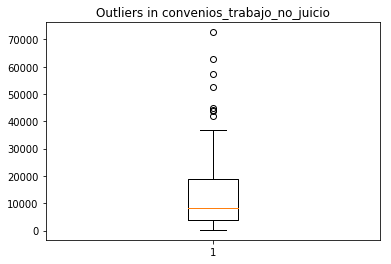

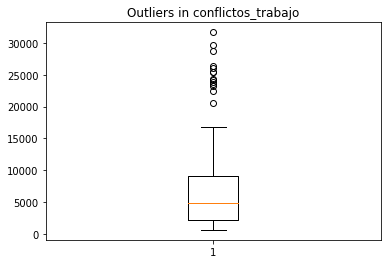

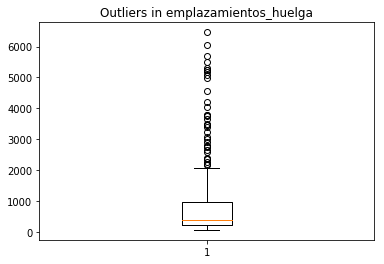

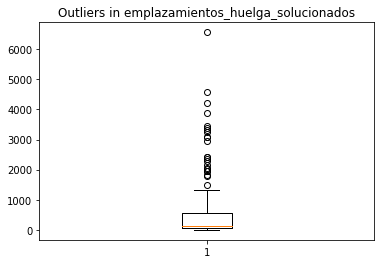

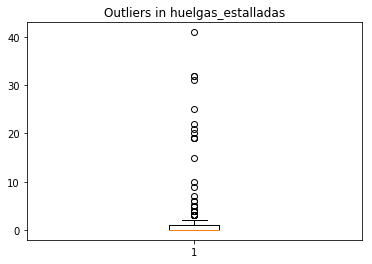

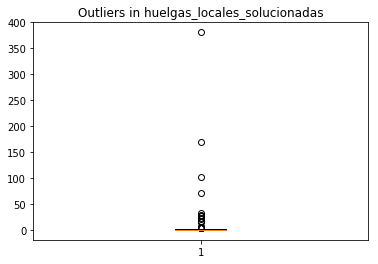

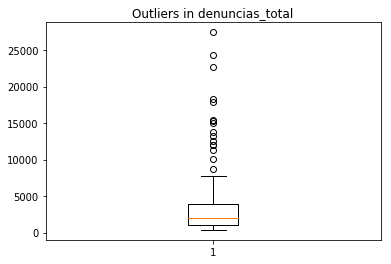

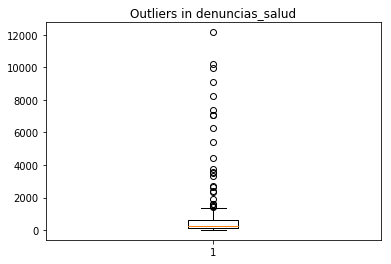

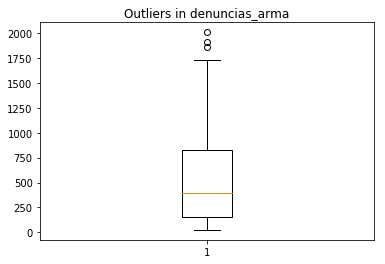

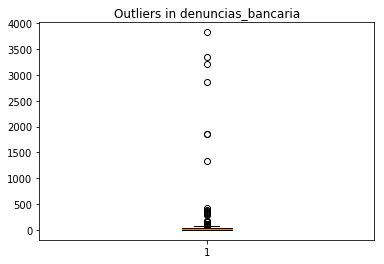

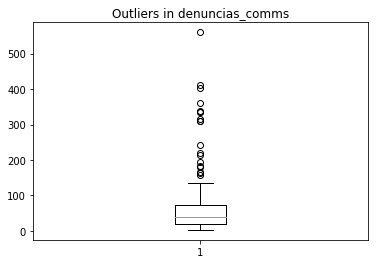

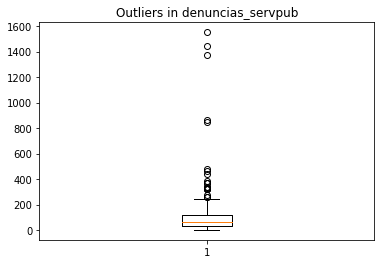

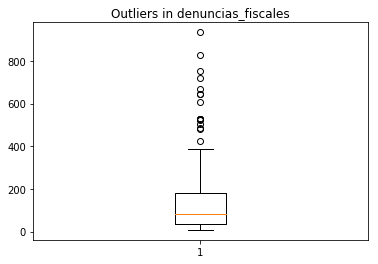

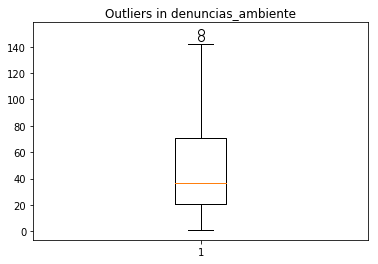

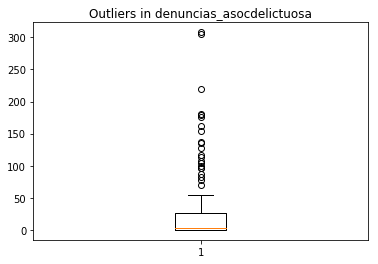

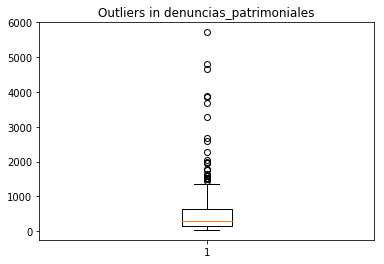

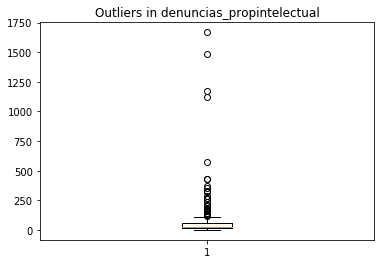

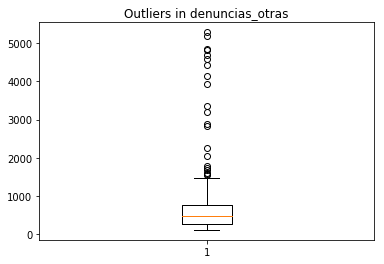

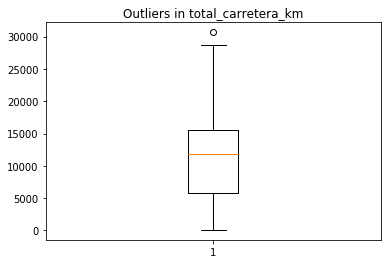

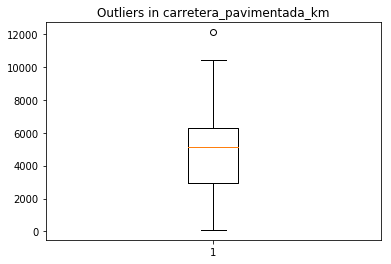

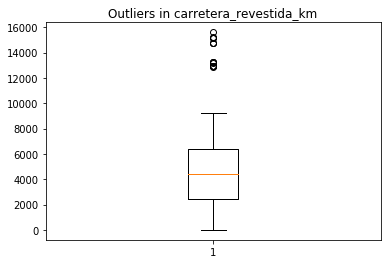

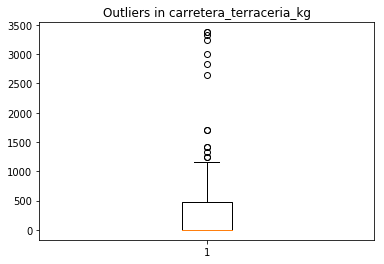

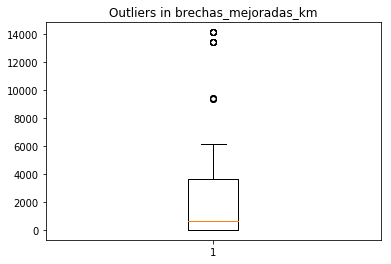

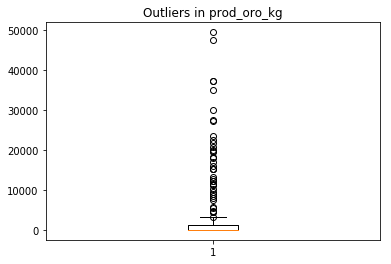

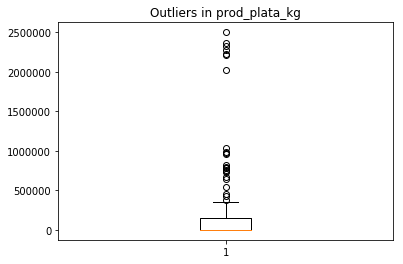

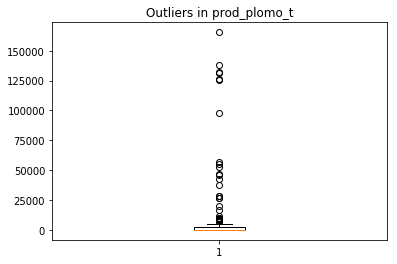

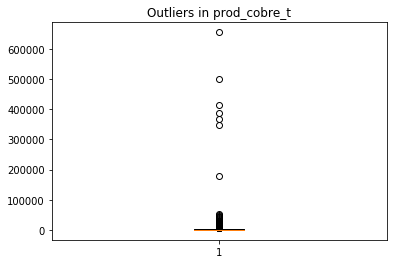

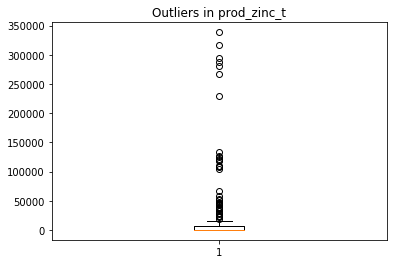

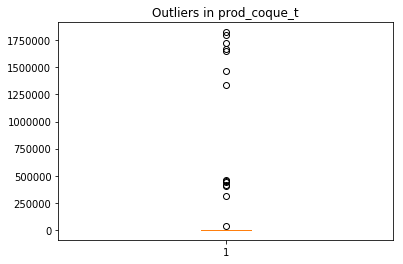

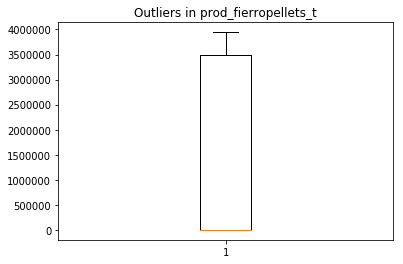

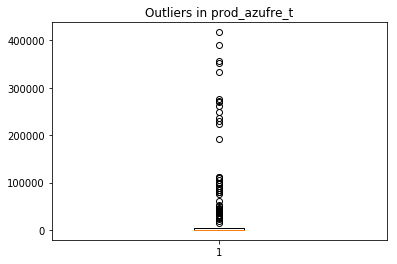

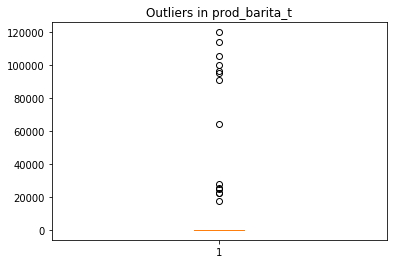

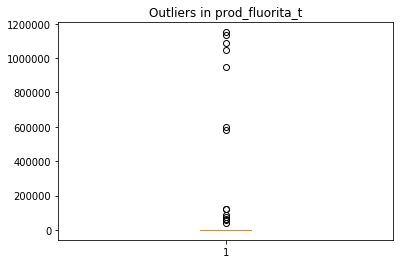

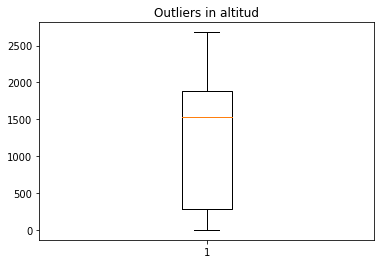

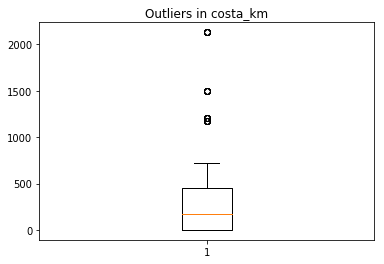

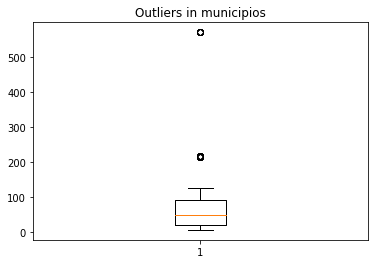

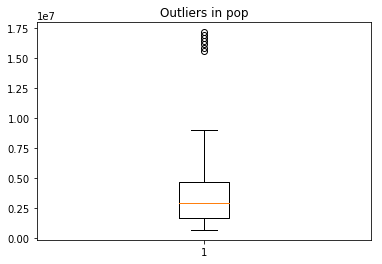

In [342]:
epc.box_plot(working_df)

Most variables have outliers, but I can generally group the variables with outliers in two: population dependent variables and metal production variables. 

Given that a lot of Mexican states are more populous than others and some states have the natural resources to produce metals, the outliers make sense and might not be indicative of flawed data. To be extra sure, I think it would be appropriate to convert all the population dependent variables to per capita and, after the PCA and Cluster Analysis, likely discretize. I'll drop the population variable after the per capita change.

Thankfully, our population dependent columns are all in order between indexes 2-24. It should be pretty straightforward dividing them by population.

In [343]:
# per capita calculation
working_df.iloc[:,2:24] = working_df.iloc[:,2:24].div(working_df.iloc[:,-1], axis=0)
del working_df['pop']
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,0.033559,0.016098,0.017460,0.002281,0.000120,0.002256,0.002709,0.000272,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,0.033373,0.016649,0.016724,0.001920,0.000084,0.000726,0.002900,0.001005,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,0.035786,0.018134,0.017652,0.002445,0.000117,0.001932,0.002555,0.000456,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,0.033881,0.017149,0.016733,0.002360,0.000127,0.004031,0.001409,0.000172,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,0.029674,0.014880,0.014794,0.002235,0.000119,0.008386,0.002828,0.000196,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


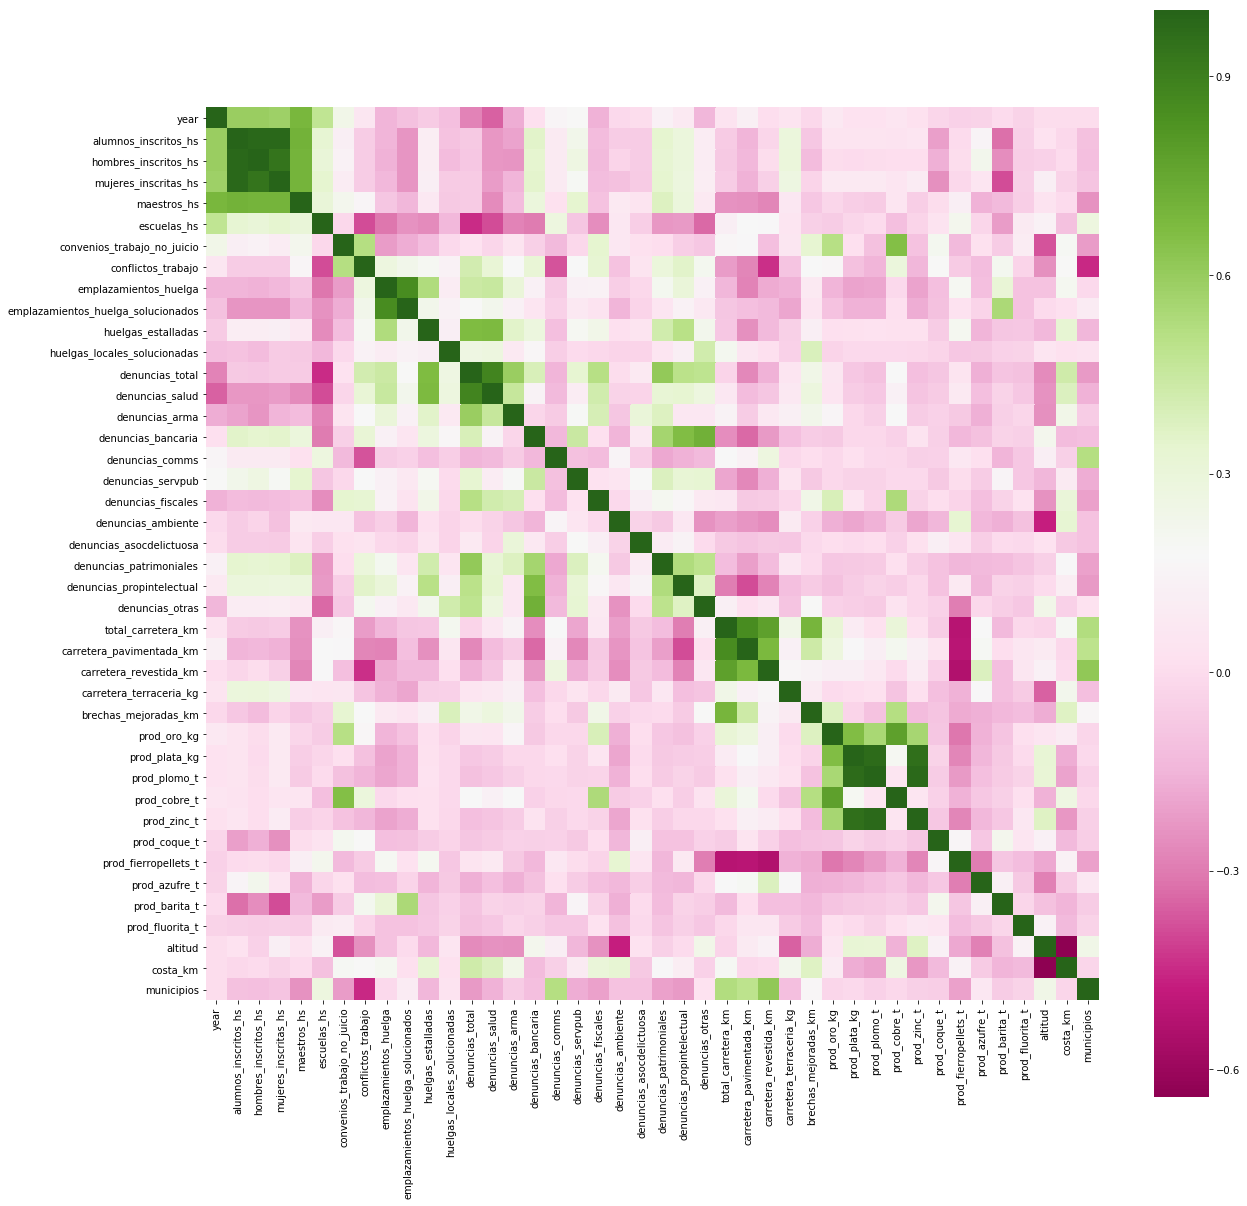

In [344]:
epc.explore_potential_correlations(working_df)

A couple of things to note from the correlation heatmap:
- There's significant correlation between all the education variables, so we'd expect them to group together in a Principal Components Analysis
- There's generally a positive correlation between several of the denuncias variables, so we'd expect them to once again group together under a Principal Component Analysis. We'd also expect the carretera variables to group together.
- There's positive correlation between the production of different metals variables, but only among the more common ones like gold, silver, copper, which is interesting to say the least. Curious to see if the group together in PCA or not.

### 2) Principal Components Analysis 

The first step in doing this analysis is standardizing all the variables, which is different than normalizing theoretically and functionally. This is necessary since a lot of machine learning algorithms, PCA included, are optimized for standardized variables -- or variables that have the same units across them. 
- Theoretically, standardizing transforms the variables onto the unit scale (mean = 0, variance = 1) which measures how variables are distributed from the mean. Functionally, I'm only doing this to implement the PCA algorithm which requires it. I'll keep working_df intact for the next step, which is normalization.
- Theoretically, normalizing transforms the variables into the same units, and standardization is an option in normalizing but not the only one. You can normalize by rank, z-score, and more. Functionally, I'll do that in the next step.

I've been having considerable trouble in getting entidad to show up on PCA and Cluster graphs, so I'll be turning the states into integers. I'll create a dictionary to assign values and use a loop that utilizes jaro-winkler to match up the different strings. From there, I'll store the new values in a list that I'll turn into the new entidad column

In [345]:
replacing = {'Aguascalientes':1, 'Baja California':2, 'Baja California Sur':3, 'Campeche':4, 'Coahuila de Zaragoza':5, 'Colima':6, 'Chiapas':7, 'Chihuahua':8, 'Ciudad de México /b':9, 'Durango':10, 'Guanajuato':11, 'Guerrero':12, 'Hidalgo':13, 'Jalisco':14, 'México':15, 'Michoacán de Ocampo':16, 'Morelos':17, 'Nayarit':18, 'Nuevo León':19, 'Oaxaca':20, 'Puebla':21, 'Querétaro':22, 'Quintana Roo':23, 'San Luis Potosí':24, 'Sinaloa':25, 'Sonora':26, 'Tabasco':27, 'Tamaulipas':28, 'Tlaxcala':29, 'Veracruz de Ignaxio de la Llave':30, 'Yucatán':31, 'Zacatecas':32} 

In [346]:
new_col = []
for c in working_df['entidad']:
    for state, rep in replacing.items():
        if jellyfish.jaro_distance(c.strip(), state) > 0.95:
            new_col.append(state)

The code below turns states into their clean state values. It can easily be modified into integer values if need be.

In [347]:
working_df['entidad'] = pd.Series(new_col)

In [348]:
new = working_df.set_index(['entidad', 'year'])
new.head()

,,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
entidad,year,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,2010,0.033559,0.016098,0.017460,0.002281,0.000120,0.002256,0.002709,0.000272,0.000163,0.000000,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
Baja California,2010,0.033373,0.016649,0.016724,0.001920,0.000084,0.000726,0.002900,0.001005,0.000313,0.000010,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
Baja California Sur,2010,0.035786,0.018134,0.017652,0.002445,0.000117,0.001932,0.002555,0.000456,0.000196,0.000002,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
Campeche,2010,0.033881,0.017149,0.016733,0.002360,0.000127,0.004031,0.001409,0.000172,0.000012,0.000000,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
Coahuila de Zaragoza,2010,0.029674,0.014880,0.014794,0.002235,0.000119,0.008386,0.002828,0.000196,0.000037,0.000000,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


This first function takes the dataframe we're hoping to reduce (new) and the number of components we're hoping to reduce it to, in this case fifteen. It returns:
- **pca**: a PCA class that's our reduced data with the components we indicated
- **y_pca**: an array of the principal components as vectors

In [349]:
pca, y_pca = epc.pca(new, 15)

Our next function creates a pandas dataframe where the columns are our principal components, and maintains our target variables. 

The function not only creates the pandas dataframe, but also explains how much variance is explained by the principal components themselves.

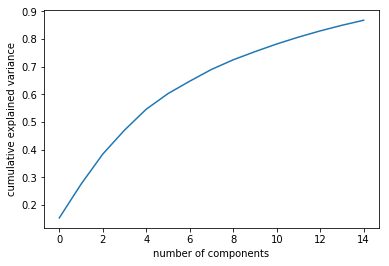

Variance explained for first 15 components:
[ 0.15317816  0.12180898  0.10897156  0.08646727  0.07580268  0.05622038
  0.04500032  0.04246213  0.0347753   0.02949847  0.02765391  0.02486901
  0.02249911  0.02025663  0.01824305]


In [350]:
pca_df = epc.pca_df(working_df, pca, y_pca, 15, 'entidad', 'year')

This is a fairly weak Principal Component Analysis -- reducing the dimensionality to two columns only helps explain about 37% of the variance. This means that there's likely an issue with our original data. Once we get to 15 components, then we're talking about capturing 90% of the variance.

In [351]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,entidad,year
0,0.182111,-0.046460,-2.858183,1.508487,0.891847,0.074259,-0.866583,0.044160,0.796629,0.675671,-0.559513,0.270038,-1.025569,-0.639786,0.764062,Aguascalientes,2010
1,10.241226,-4.640748,0.389917,-0.091450,-2.081136,5.709713,0.698993,0.256149,-0.969526,3.724245,1.153774,2.653504,0.971904,0.812380,-0.845702,Baja California,2010
2,3.429386,-0.463209,-1.605180,-0.916816,0.996476,1.913776,0.950676,0.182651,1.083633,-0.348844,-0.041974,0.293507,1.403545,-0.288178,-0.868470,Baja California Sur,2010
3,0.051744,-0.065339,-2.651899,-0.786417,2.035548,1.570643,0.498654,-1.070185,1.745847,-0.885843,-0.597890,-0.057648,0.583108,-0.187322,0.188170,Campeche,2010
4,-1.200888,-2.025912,-2.524323,1.484152,1.712407,-2.673509,-1.104159,-1.463942,-0.827425,0.560219,1.463818,3.663582,1.348420,-0.467588,0.932047,Coahuila de Zaragoza,2010


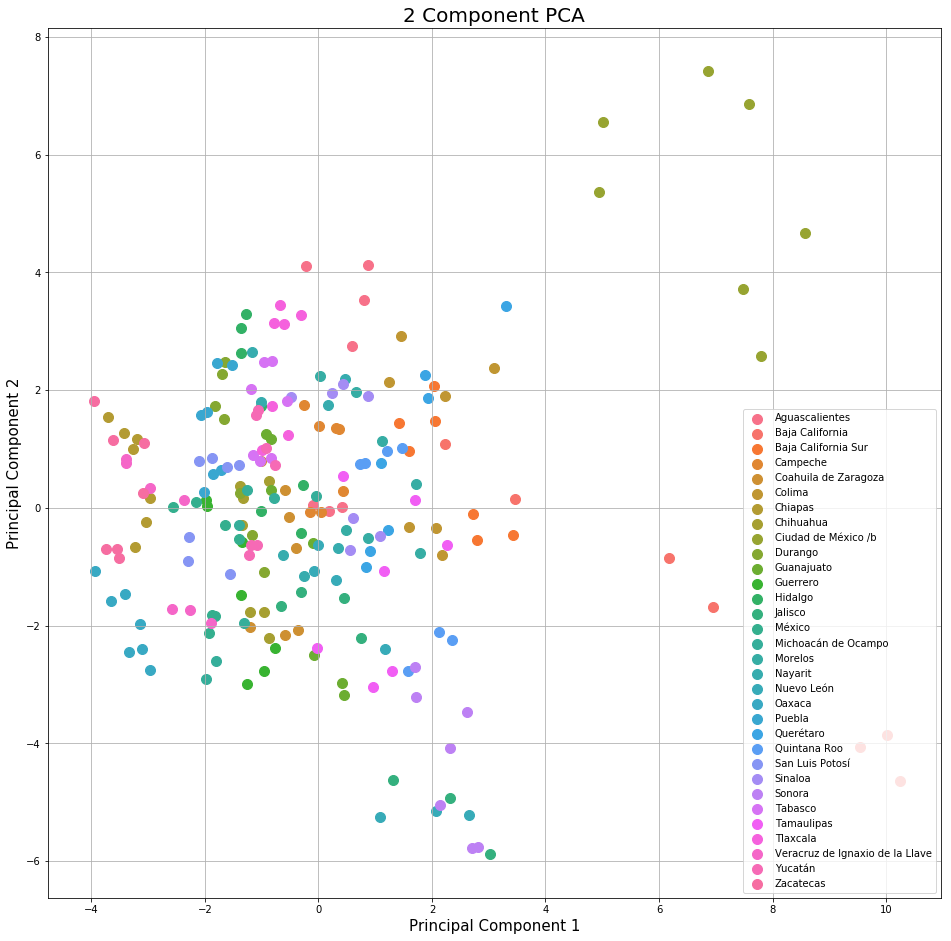

In [352]:
epc.two_dimension_pca_graph(pca_df, 'entidad')

This is the Principal Components Graph for our current dataset. The states seem to group around each other, which is a positive result. There are other groupings evident here, but generally speaking this is incredibly disperse and there's no indication that one principal component is better than another. As I build this out, I'll take a closer look at this year by year

In [361]:
loadings = epc.factor_loadings(pc, working_df, pca_df, 'entidad', 'year')

In [362]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
alumnos_inscritos_hs,0.0858484,0.824022,0.400615,-0.271244,-0.0788689,0.0060411,0.0260098,0.181782,-0.0230219,0.11083,0.0499497,0.0112753,-0.0733831,0.0422174,0.0336113
hombres_inscritos_hs,0.0864562,0.81756,0.356125,-0.30603,-0.079062,-0.0280758,0.0949553,0.188241,-0.0327823,0.0777151,0.0303732,0.0756006,-0.0319421,0.0920849,0.0357658
mujeres_inscritas_hs,0.0823371,0.804099,0.437267,-0.223316,-0.0760525,0.0440763,-0.0521141,0.168551,-0.0113246,0.144289,0.0702423,-0.061185,-0.117406,-0.0150604,0.0300888
maestros_hs,0.212982,0.733533,0.188387,-0.184216,0.119201,-0.146157,-0.200186,0.135545,-0.0851058,-0.11912,0.176637,-0.056437,0.1124,-0.0642243,-0.0161834
escuelas_hs,-0.482275,0.38801,-0.022148,-0.280535,0.0342486,0.154056,-0.321824,0.0958152,-0.162637,0.0550799,0.226829,-0.022475,0.132415,0.0900459,-0.0317516
convenios_trabajo_no_juicio,0.0946396,-0.0993698,0.378418,-0.356498,0.57773,-0.45992,-0.100116,0.0120223,0.00441494,-0.00853048,-0.0232211,0.0992252,0.0474043,0.104168,0.0746521
conflictos_trabajo,0.62216,-0.137809,0.0854301,0.0460154,0.306988,-0.482084,0.00606522,0.0610813,0.107946,0.027198,0.0804737,0.0739475,0.0128646,-0.0140694,0.0105565
emplazamientos_huelga,0.568286,-0.270254,-0.231464,0.10266,-0.262622,0.123802,-0.0747434,0.575005,-0.0671291,0.109546,0.0696868,-0.0760407,-0.000516295,0.0329408,-0.0192505
emplazamientos_huelga_solucionados,0.332022,-0.31866,-0.268992,0.1696,-0.272017,-0.108138,-0.0448985,0.702416,-0.0118136,-0.00754172,0.0679852,-0.158958,-0.0193608,0.0248565,0.0376672
huelgas_estalladas,0.660418,-0.0659217,0.150048,0.0619493,-0.159064,0.391698,-0.0470876,0.114226,-0.0773027,0.221548,0.112279,0.208757,0.0825252,0.199828,-0.148261


The factor loadings show which variables influenced the principal components we wound up building, and are a measure of how variables relate to each other. For our four largest principal vectors, the loadings seem to make sense.
- PC1, which explains 15% of the variance, is largely explained by denuncias and conflictos laborales variables which jives with our idea to use this dataset as a measure of organized crime to some extent.
- PC2, which explains 12% of the variance, is largely explained by education variables which could also be important in determining if the youth in that State are in school or not and could be a measure of organized crime.
- PC3, which explains 10% of the variance, is largely explained by metal production variables and total highways in the State which could be a measure of illegal mining and transportation of illicit goods and could give a sense of presence of organized crime.
- PC4, which explains 8% of the variance, is largely explained by altitude and metal production variables again in possible reference to illegal mining and the altitude required to grow crops like coca.

Together, these four principal components explain 45% of the variance, which isn't a lot regardless. There's no need to reduce the dimensionality of our dataset. We'll proceed with what we have but this was a good explanatory analysis and it seems our dataset, though likely weak, is good enough to continue

### 3) Cluster Analysis

There's a whole range of clustering algorithms that could work in this scenario, but I'll use affinity propagation here because it creates clusters between pairs of samples until convergence. It describes a dataset using a small number of examples which it identifies as representative of the other samples -- and it does this iteratively.

We'll work from our previously standardized dataset

In [363]:
from sklearn import cluster, covariance, manifold


# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = new.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(working_df.iloc[:,0].values[labels == i])))

/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


Cluster 1: Aguascalientes
Cluster 2: Baja California
Cluster 3: Baja California Sur
Cluster 4: Campeche
Cluster 5: Colima
Cluster 6: Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo
Cluster 7: Morelos
Cluster 8: Nayarit
Cluster 9: Puebla
Cluster 10: San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí
Cluster 11: Sonora, Sonora
Cluster 12: Tlaxcala
Cluster 13: Yucatán
Cluster 14: Aguascalientes
Cluster 15: Baja California
Cluster 16: Baja California Sur
Cluster 17: Campeche
Cluster 18: Colima
Cluster 19: Guanajuato, Guanajuato, Oaxaca, Guanajuato
Cluster 20: Morelos
Cluster 21: Nayarit
Cluster 22: Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León
Cluster 23: Puebla
Cluster 24: Tlaxcala
Cluster 25: Veracruz de Ignaxio de la Llave, Veracruz de Ignaxio de la Llave, Veracruz de Ignaxio de la Llave
Cluster 26: Yucatán
C

Pretty strange results in the sense that it made some clusters that make perfect sense (Clusters 51, 65, 66) for example are all composed of the same state for different years which makes s ense. Yet, states like Colima and Campeche are grouped into seven different clusters. There's definitely something off with this data.